In [63]:
# === Importação de Bibliotecas ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from scipy.stats import norm

from utils import plot_regression_diagnostics

# === Leitura do Dataset ===
df = pd.read_excel('Real estate valuation data set.xlsx')

# 1. Análise Exploratória

* Remover variável 'No' e manter as demais

In [64]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [65]:
df.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [66]:
print(f"Forma do dataset: {df.shape}")
print(f"Número de linhas: {df.shape[0]}")
print(f"Número de colunas: {df.shape[1]}")
null_counts = df.isnull().sum()
print("Valores nulos por coluna:")
print(null_counts)
print("\nNomes das colunas e seus tipos de dados:")
for col in df.columns:
    print(f"{col}: {df[col].dtype}")


Forma do dataset: (414, 8)
Número de linhas: 414
Número de colunas: 8
Valores nulos por coluna:
No                                        0
X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

Nomes das colunas e seus tipos de dados:
No: int64
X1 transaction date: float64
X2 house age: float64
X3 distance to the nearest MRT station: float64
X4 number of convenience stores: int64
X5 latitude: float64
X6 longitude: float64
Y house price of unit area: float64


Colunas numéricas: ['No', 'X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude', 'Y house price of unit area']


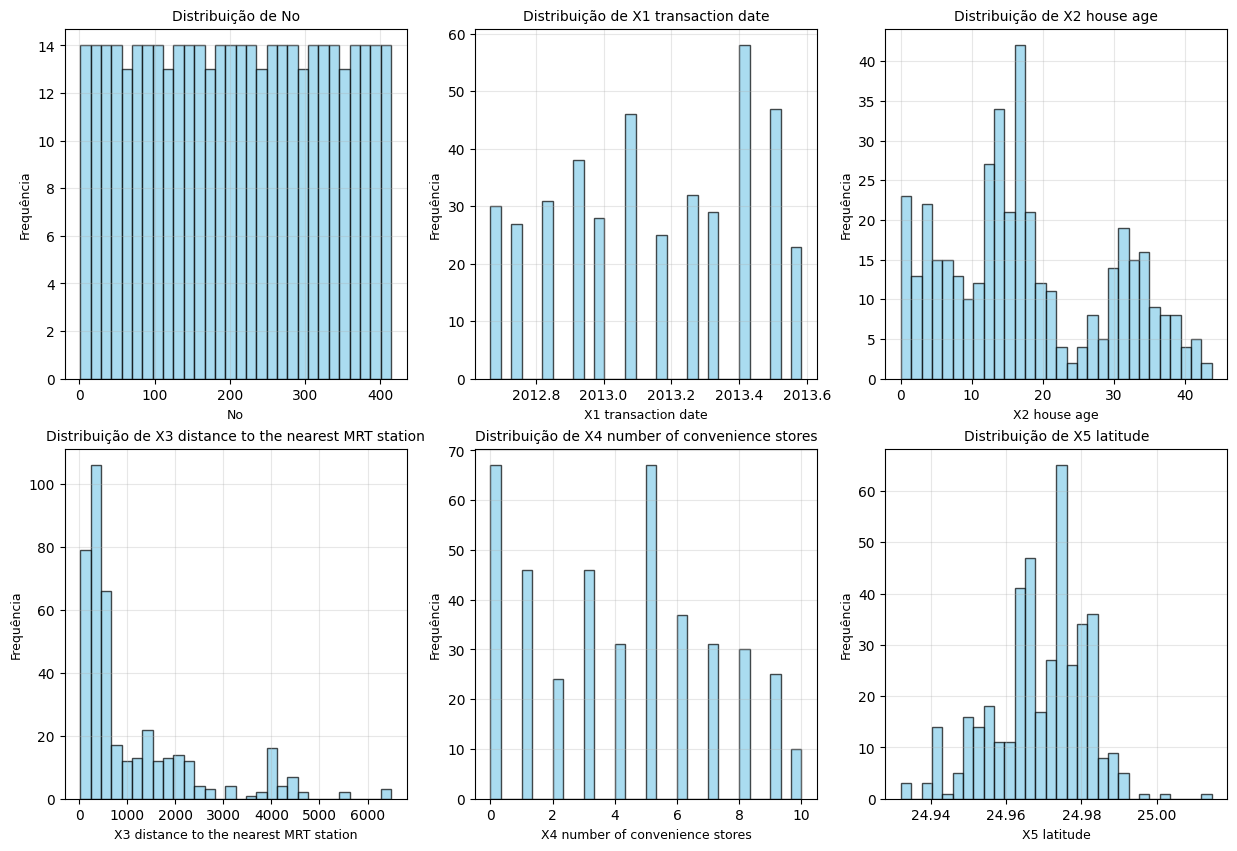

In [67]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
print(f"Colunas numéricas: {list(numeric_columns)}")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_columns):
    if i < len(axes):
        axes[i].hist(df[col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribuição de {col}', fontsize=10)
        axes[i].set_xlabel(col, fontsize=9)
        axes[i].set_ylabel('Frequência', fontsize=9)
        axes[i].grid(True, alpha=0.3)

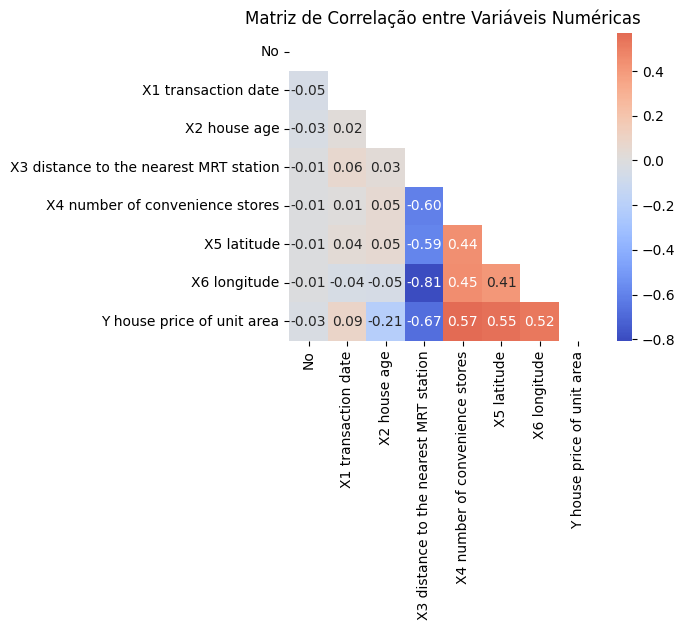

In [68]:
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(5, 4))
mask = np.triu(np.ones_like(correlation_matrix))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f');
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()


# 2. Implementação de modelos

In [69]:
# #remover outliers

# # Remover outliers usando o método do IQR para todas as colunas numéricas exceto 'No'
# numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'No']
# Q1 = df[numeric_cols].quantile(0.25)
# Q3 = df[numeric_cols].quantile(0.75)
# IQR = Q3 - Q1
# df_original = df.copy()
# # Mantém apenas as linhas que não são outliers em nenhuma coluna numérica
# df = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)].reset_index(drop=True)
# print(f"Shape após remoção de outliers: {df.shape} - {df.shape[0]/df_original.shape[0]*100}%")


In [70]:
X = df.drop('No', axis = 1).iloc[:, :-1]  # Todas as colunas exceto a última
y = df.iloc[:, -1]   # Última coluna (preço)

# Dividir em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Normalizar os dados (importante para redes neurais, mas para regressão linear não é necessário)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Treino: {X_train.shape}")
print(f"Teste: {X_test.shape}")

Treino: (289, 6)
Teste: (125, 6)


Coeficiente de correlação de Pearson (Treino): 0.7620
R² (Treino): 0.5806
Coeficiente de correlação de Pearson (Teste): 0.7683
R² (Teste): 0.5800


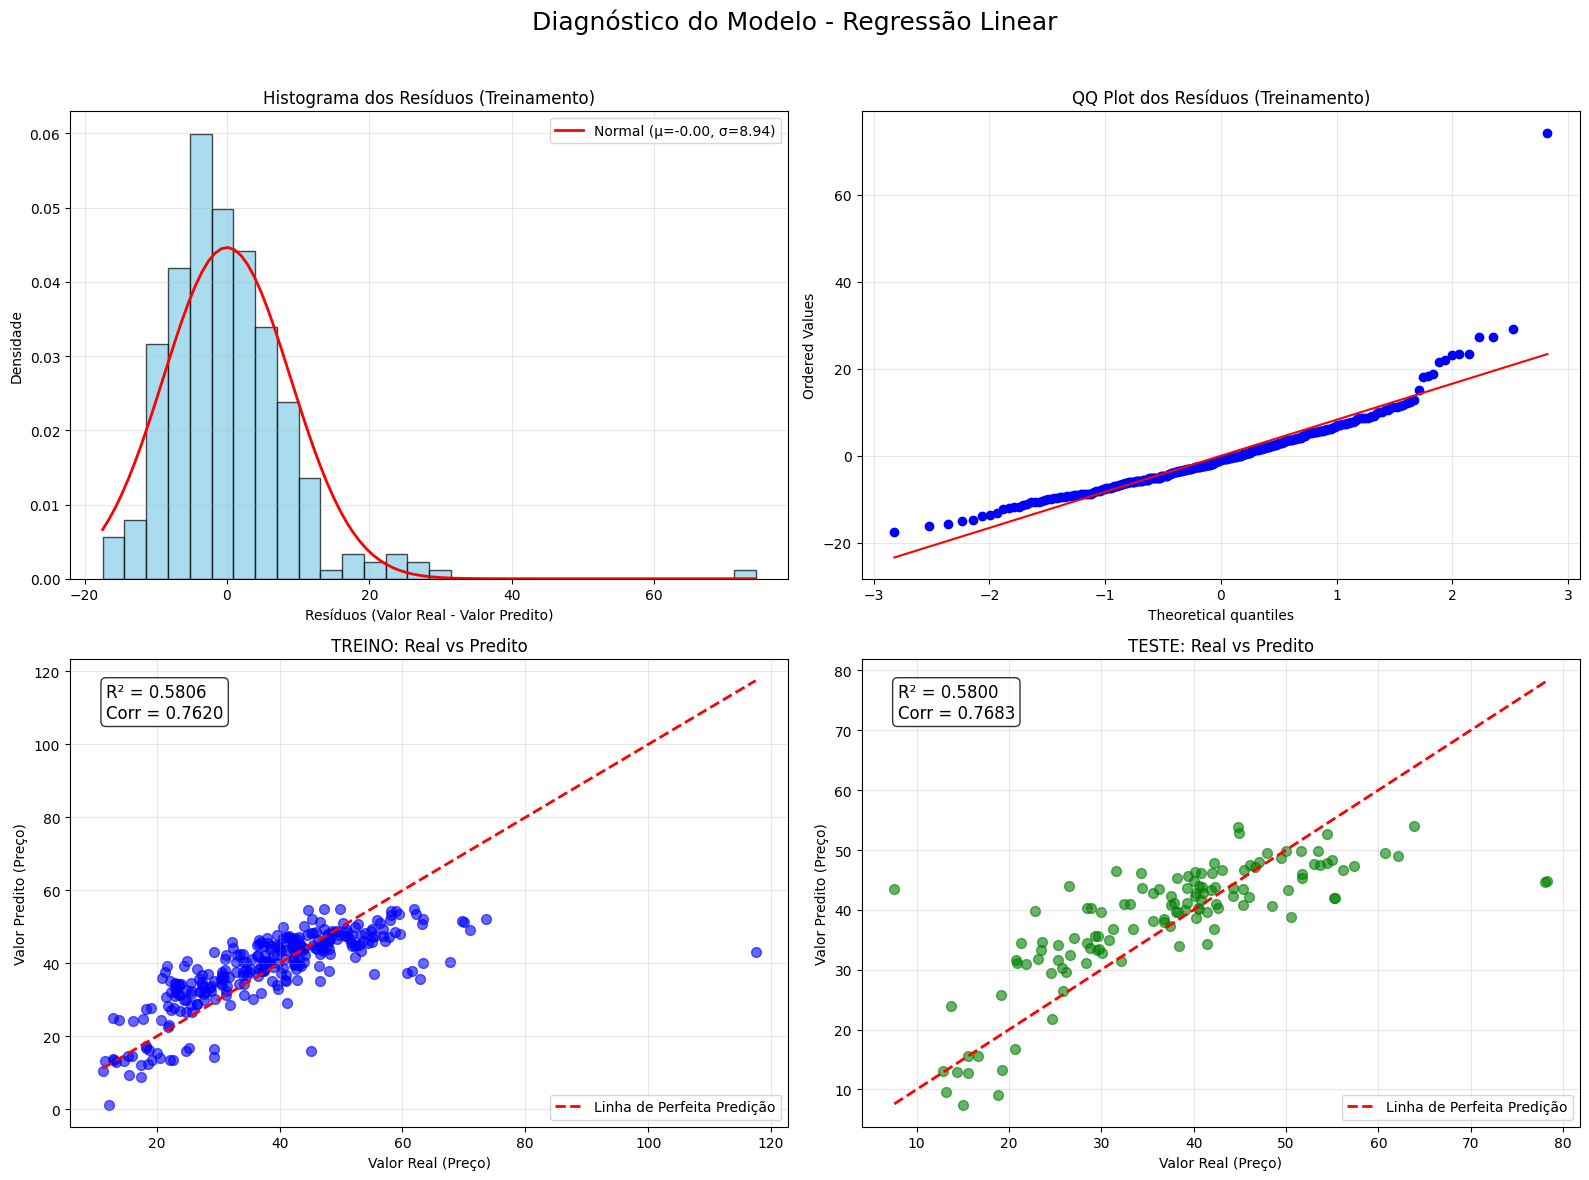

In [71]:
# Regressão Linear
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)
lr_corr_train, lr_corr_test, lr_r2_train, lr_r2_test = plot_regression_diagnostics(y_train = y_train, y_train_pred = lr_train_pred, y_test = y_test, y_test_pred = lr_test_pred, title = 'Regressão Linear')



Coeficiente de correlação de Pearson (Treino): 0.8422
R² (Treino): 0.7092
Coeficiente de correlação de Pearson (Teste): 0.8136
R² (Teste): 0.6582


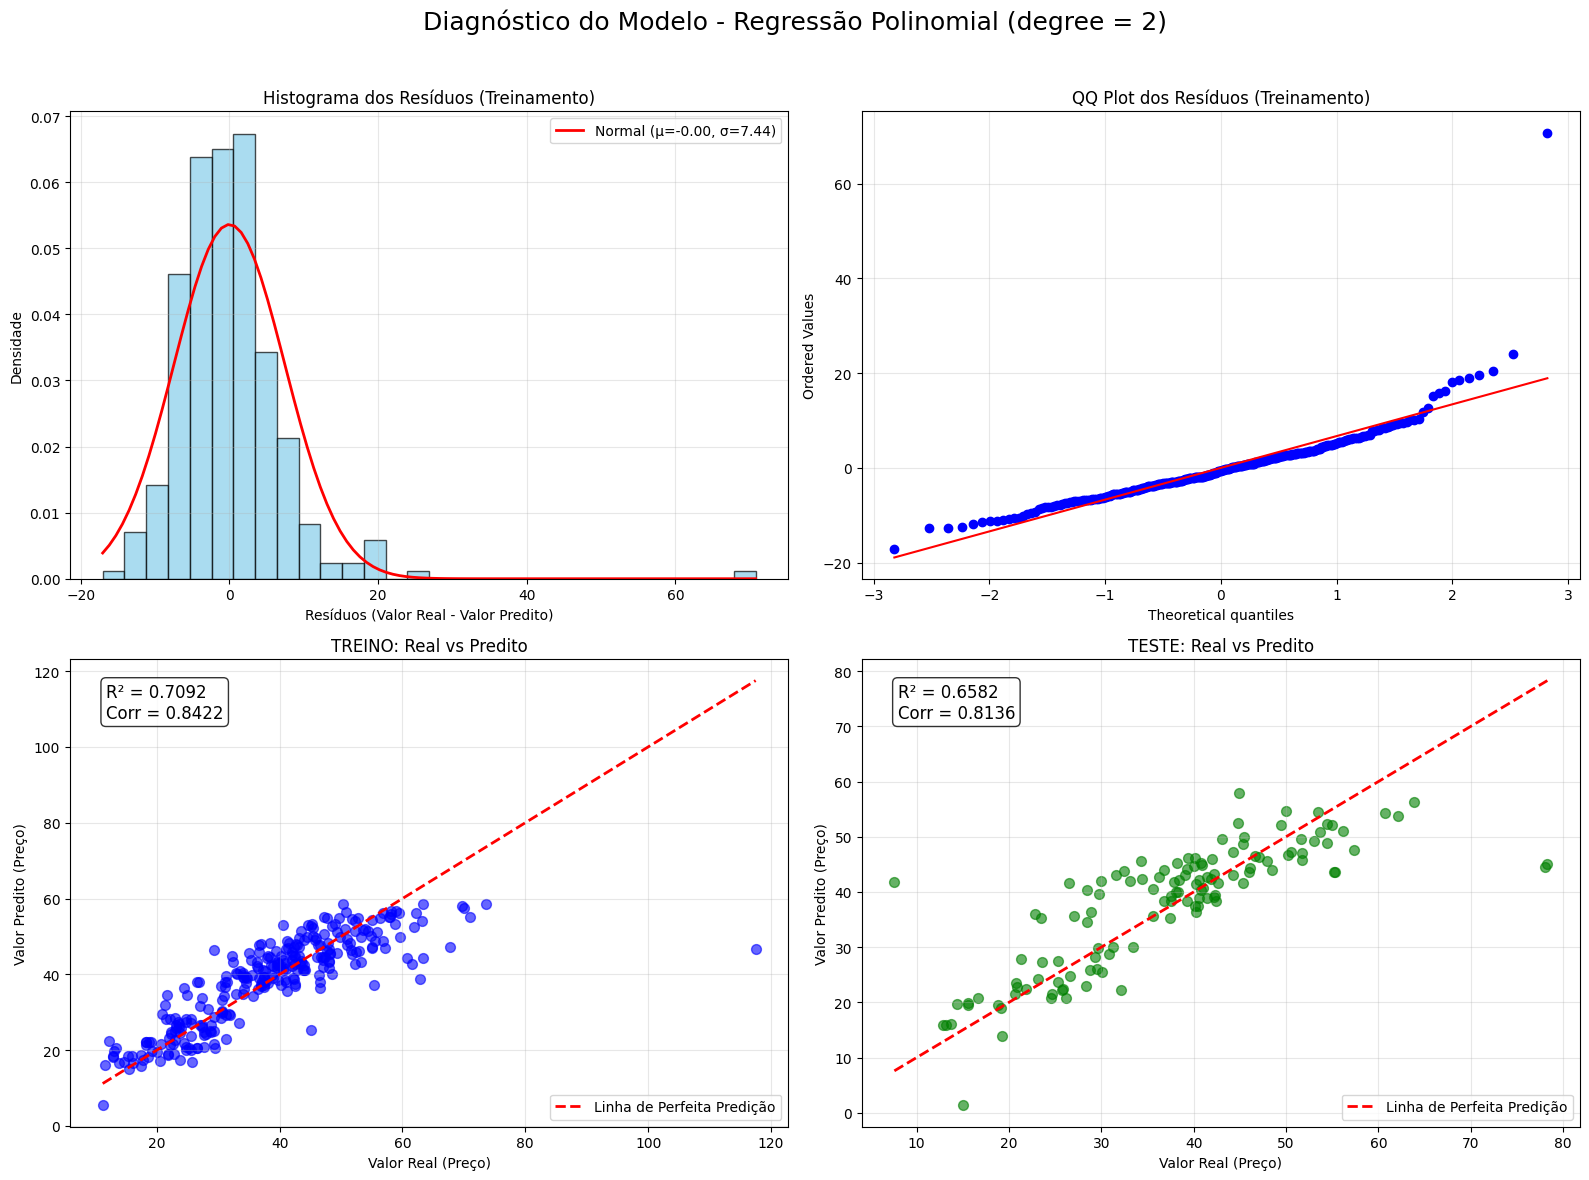

In [72]:
#Regressão Polinomial

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
poly_train_pred = poly_model.predict(X_train_poly)
poly_test_pred = poly_model.predict(X_test_poly)

lr_poly_2_corr_train, lr_poly_2_corr_test, lr_poly_2_r2_train, lr_poly_2_r2_test = plot_regression_diagnostics(y_train = y_train, y_train_pred = poly_train_pred, y_test = y_test, y_test_pred = poly_test_pred, title = 'Regressão Polinomial (degree = 2)')

Coeficiente de correlação de Pearson (Treino): 0.8843
R² (Treino): 0.7820
Coeficiente de correlação de Pearson (Teste): 0.5914
R² (Teste): 0.1320


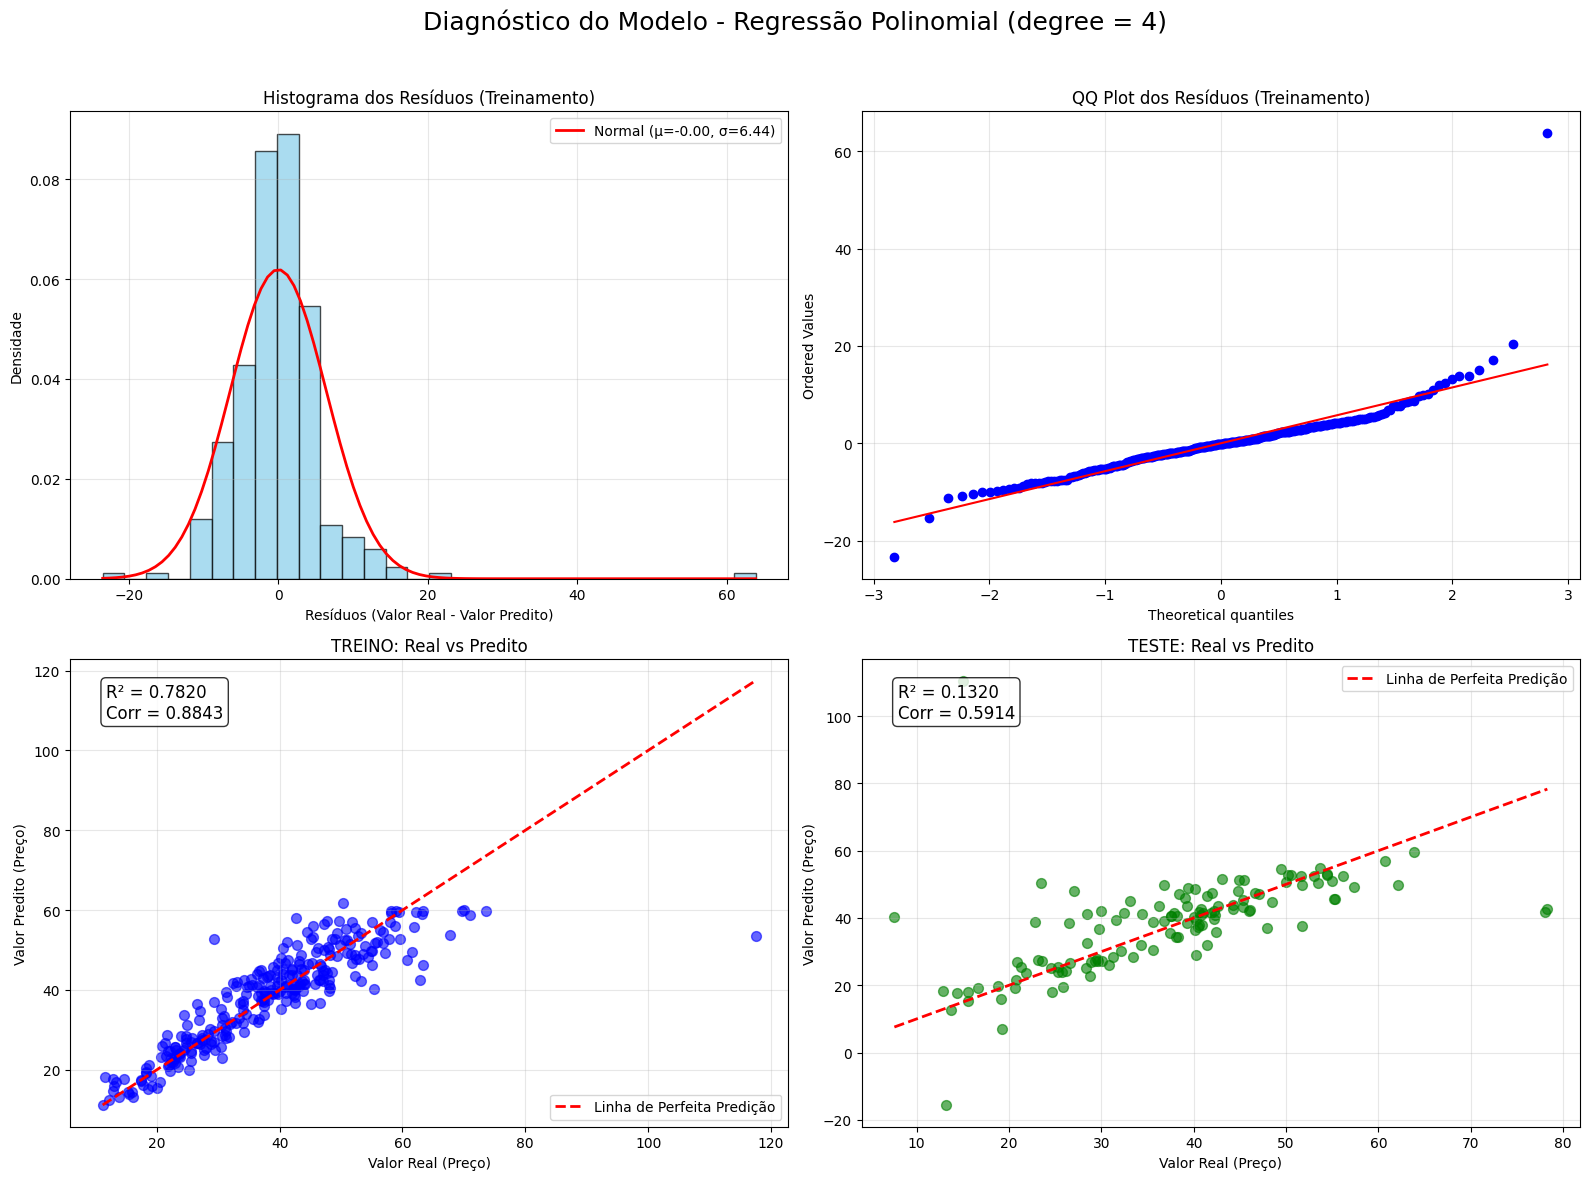

In [73]:
#Regressão Polinomial grau 4
poly = PolynomialFeatures(degree=4)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
poly_train_pred = poly_model.predict(X_train_poly)
poly_test_pred = poly_model.predict(X_test_poly)
lr_poly_4_corr_train, lr_poly_4_corr_test, lr_poly_4_r2_train, lr_poly_4_r2_test = plot_regression_diagnostics(y_train = y_train, y_train_pred = poly_train_pred, y_test = y_test, y_test_pred = poly_test_pred, title = 'Regressão Polinomial (degree = 4)')

Coeficiente de correlação de Pearson (Treino): 0.8898
R² (Treino): 0.7917
Coeficiente de correlação de Pearson (Teste): 0.2946
R² (Teste): -1.5695


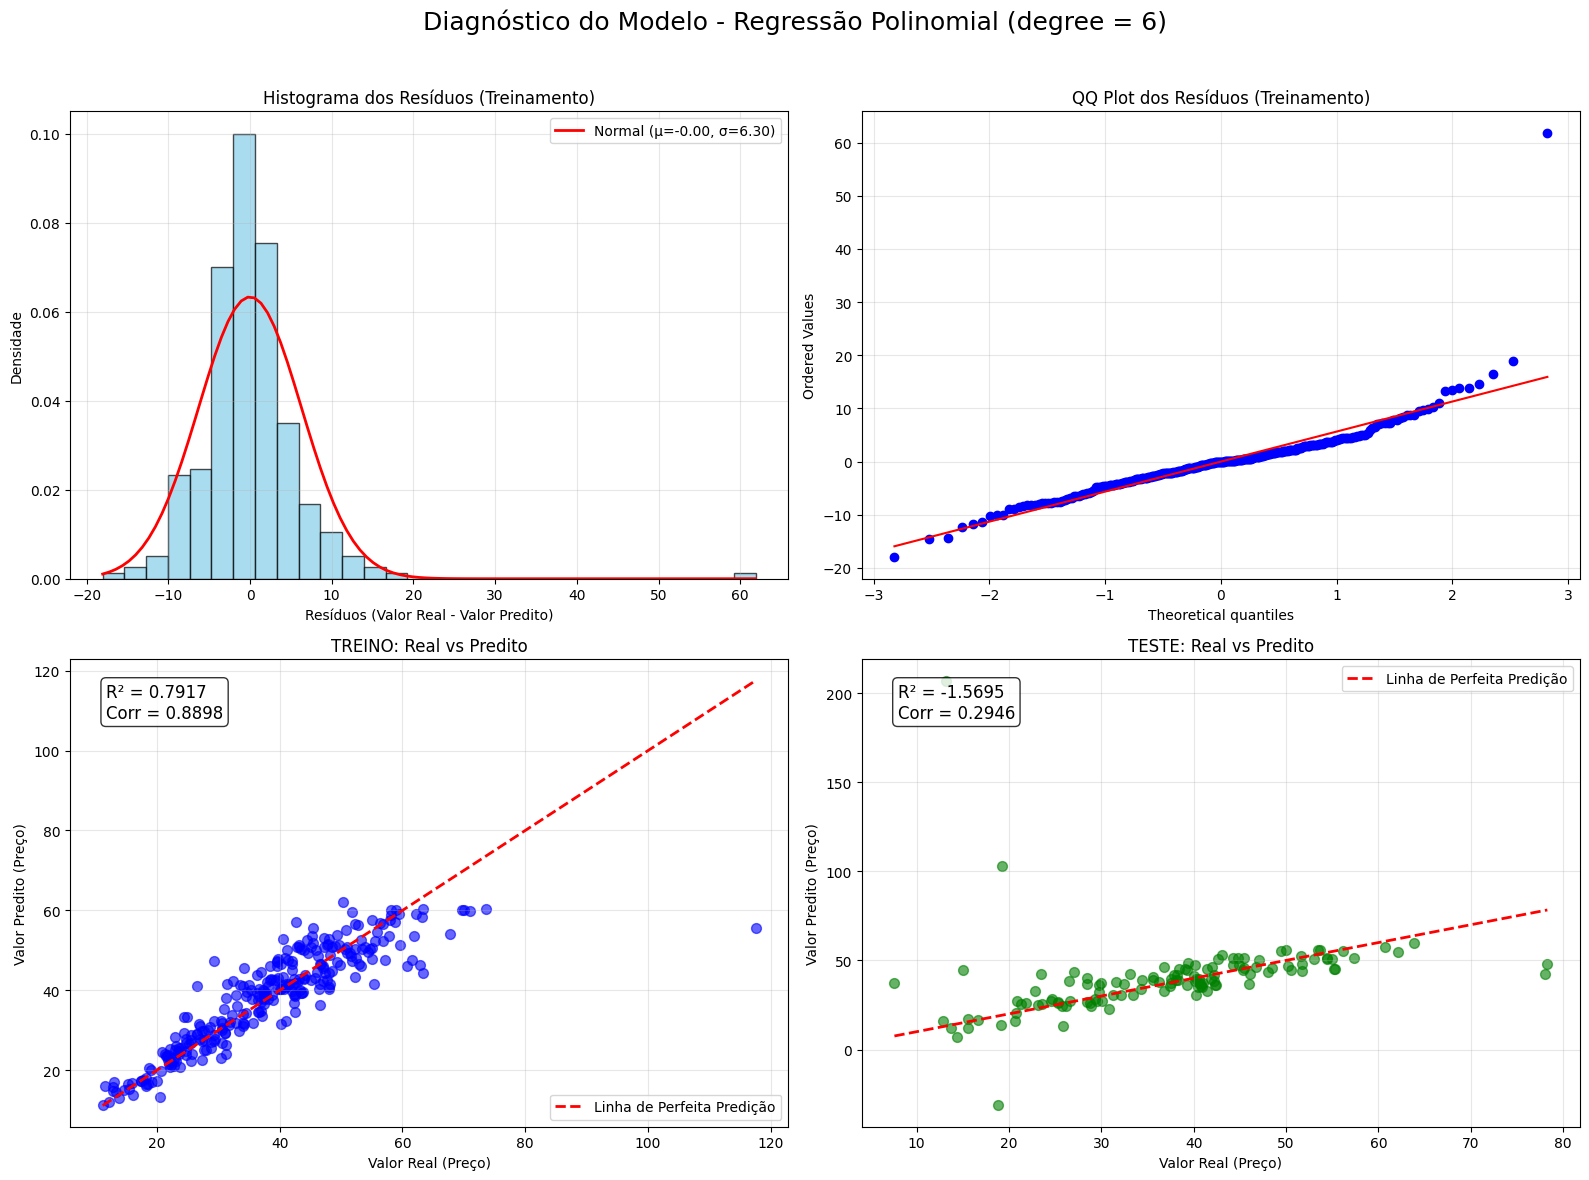

In [74]:
#Regressão Polinomial grau 6
# Regressão Polinomial grau 6
poly = PolynomialFeatures(degree=6)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
poly_train_pred = poly_model.predict(X_train_poly)
poly_test_pred = poly_model.predict(X_test_poly)
lr_poly_6_corr_train, lr_poly_6_corr_test, lr_poly_6_r2_train, lr_poly_6_r2_test = plot_regression_diagnostics(
    y_train=y_train,
    y_train_pred=poly_train_pred,
    y_test=y_test,
    y_test_pred=poly_test_pred,
    title='Regressão Polinomial (degree = 6)'
)


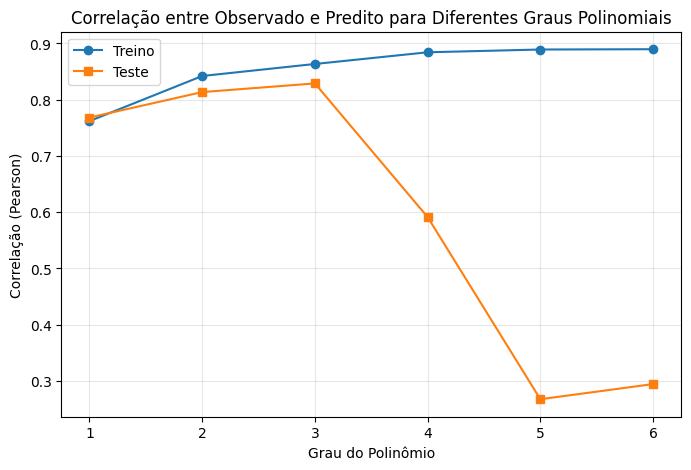

In [75]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

correlations_train = []
correlations_test = []
degrees = range(1, 7)

for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    corr_train, _ = pearsonr(y_train, y_train_pred)
    corr_test, _ = pearsonr(y_test, y_test_pred)
    correlations_train.append(corr_train)
    correlations_test.append(corr_test)

plt.figure(figsize=(8, 5))
plt.plot(degrees, correlations_train, marker='o', label='Treino')
plt.plot(degrees, correlations_test, marker='s', label='Teste')
plt.xlabel('Grau do Polinômio')
plt.ylabel('Correlação (Pearson)')
plt.title('Correlação entre Observado e Predito para Diferentes Graus Polinomiais')
plt.xticks(degrees)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Coeficiente de correlação de Pearson (Treino): 0.7307
R² (Treino): 0.5337
Coeficiente de correlação de Pearson (Teste): 0.7421
R² (Teste): 0.5402


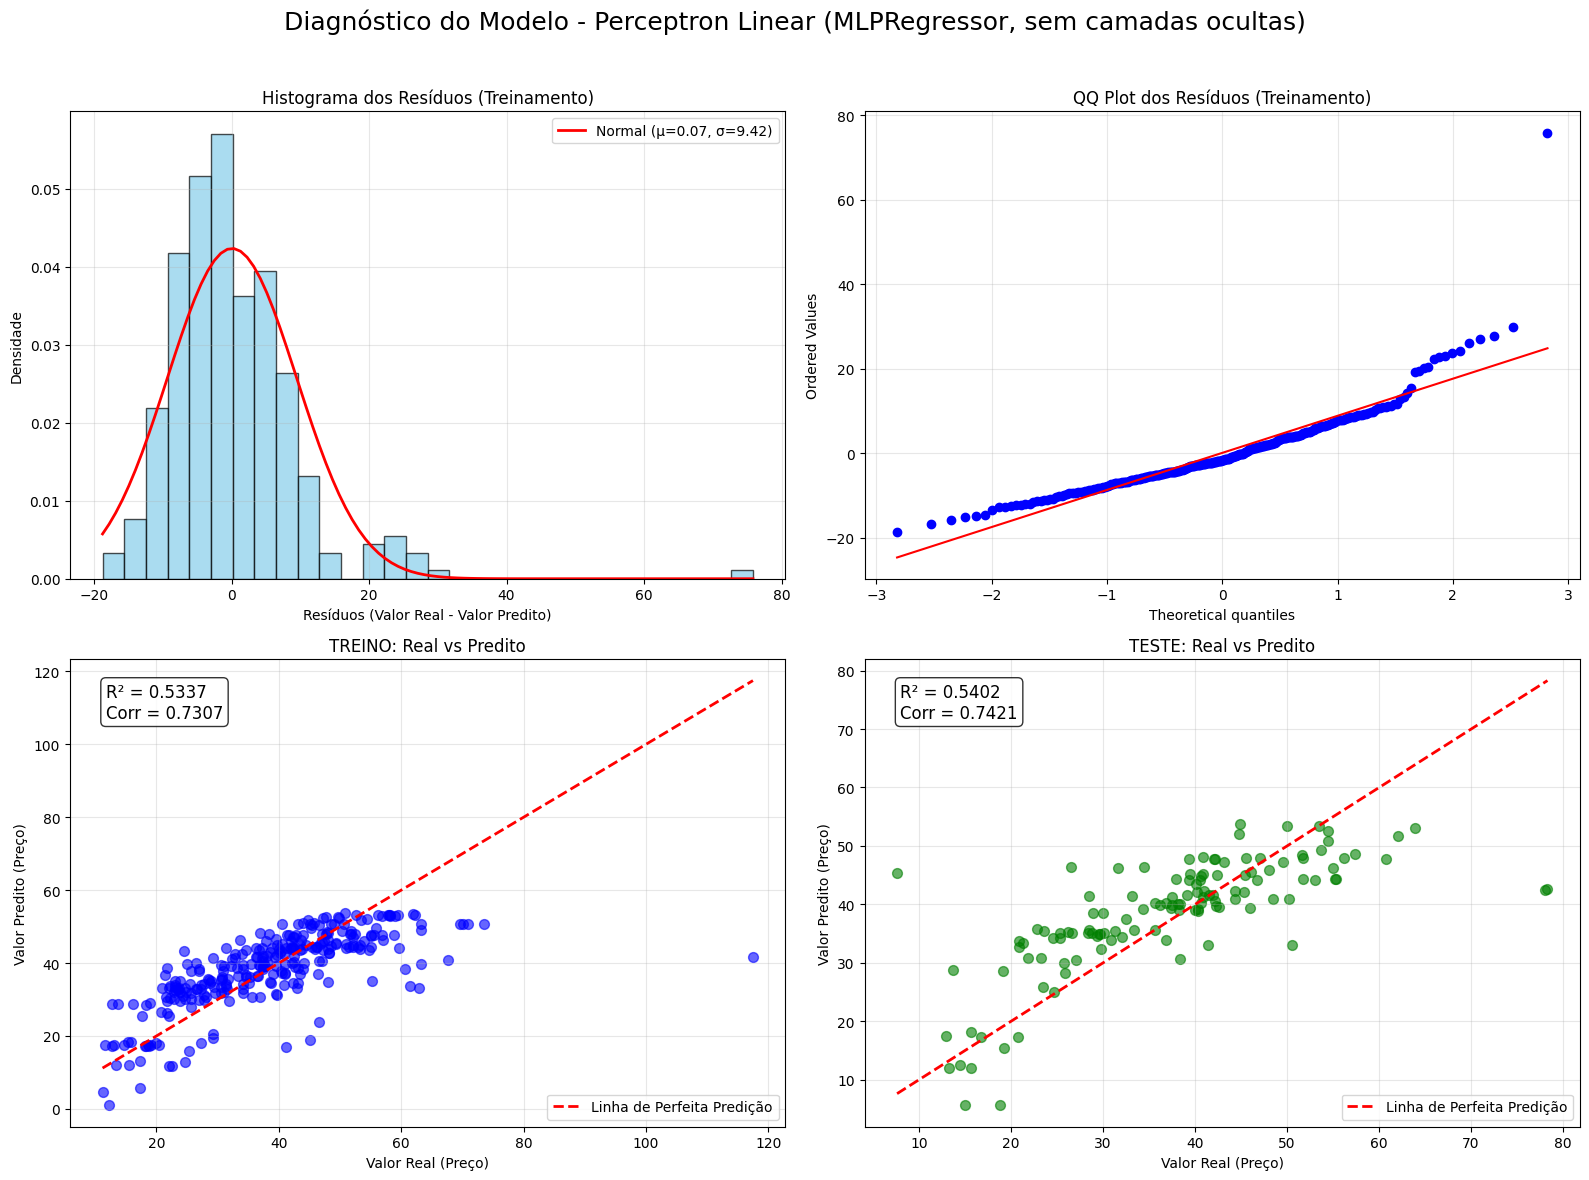

In [76]:
#  Perceptron logistico (sem camadas ocultas, saída linear)
mlp = MLPRegressor(hidden_layer_sizes=(), activation='identity', max_iter=10000, random_state=11)

# Treinamento do modelo
mlp.fit(X_train, y_train)

# Predição nos conjuntos de treino e teste
y_train_pred_mlp = mlp.predict(X_train)
y_test_pred_mlp = mlp.predict(X_test)

# Avaliação do modelo
ps_mlp_corr_train, ps_mlp_corr_test, ps_mlp_r2_train, ps_mlp_r2_test = plot_regression_diagnostics(
    y_train=y_train, 
    y_train_pred=y_train_pred_mlp, 
    y_test=y_test, 
    y_test_pred=y_test_pred_mlp, 
    title='Perceptron Linear (MLPRegressor, sem camadas ocultas)'
)



Coeficiente de correlação de Pearson (Treino): 0.7733
R² (Treino): 0.5970
Coeficiente de correlação de Pearson (Teste): 0.7962
R² (Teste): 0.6248


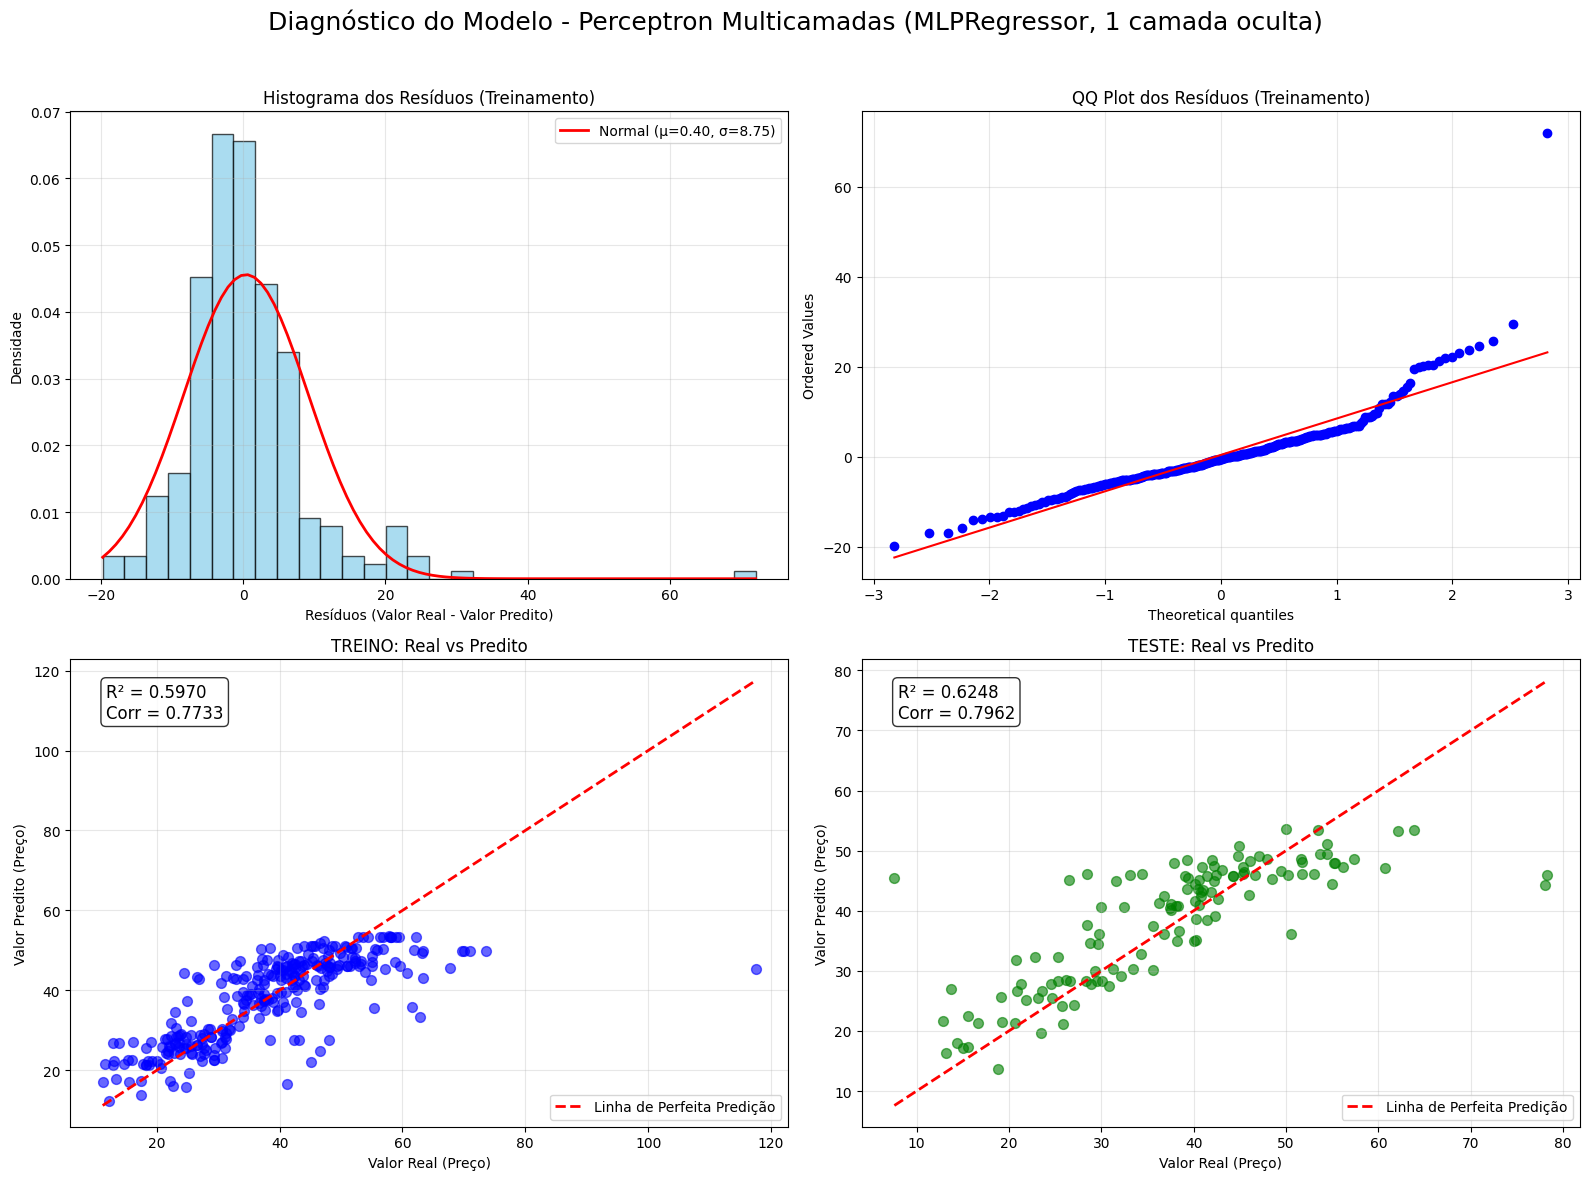

In [77]:
# Perceptron Multicamadas (MLPRegressor) com 1 camada oculta
mlp = MLPRegressor(hidden_layer_sizes=(10,), activation='relu', max_iter=10000, random_state=11)

# Treinamento do modelo
mlp.fit(X_train, y_train)

# Predição nos conjuntos de treino e teste
y_train_pred_mlp = mlp.predict(X_train)
y_test_pred_mlp = mlp.predict(X_test)

# Avaliação do modelo
mlp_1_corr_train, mlp_1_corr_test, mlp_1_r2_train, mlp_1_r2_test = plot_regression_diagnostics(
    y_train=y_train, 
    y_train_pred=y_train_pred_mlp, 
    y_test=y_test, 
    y_test_pred=y_test_pred_mlp, 
    title='Perceptron Multicamadas (MLPRegressor, 1 camada oculta)'
)


Coeficiente de correlação de Pearson (Treino): 0.7633
R² (Treino): 0.5825
Coeficiente de correlação de Pearson (Teste): 0.7777
R² (Teste): 0.5938


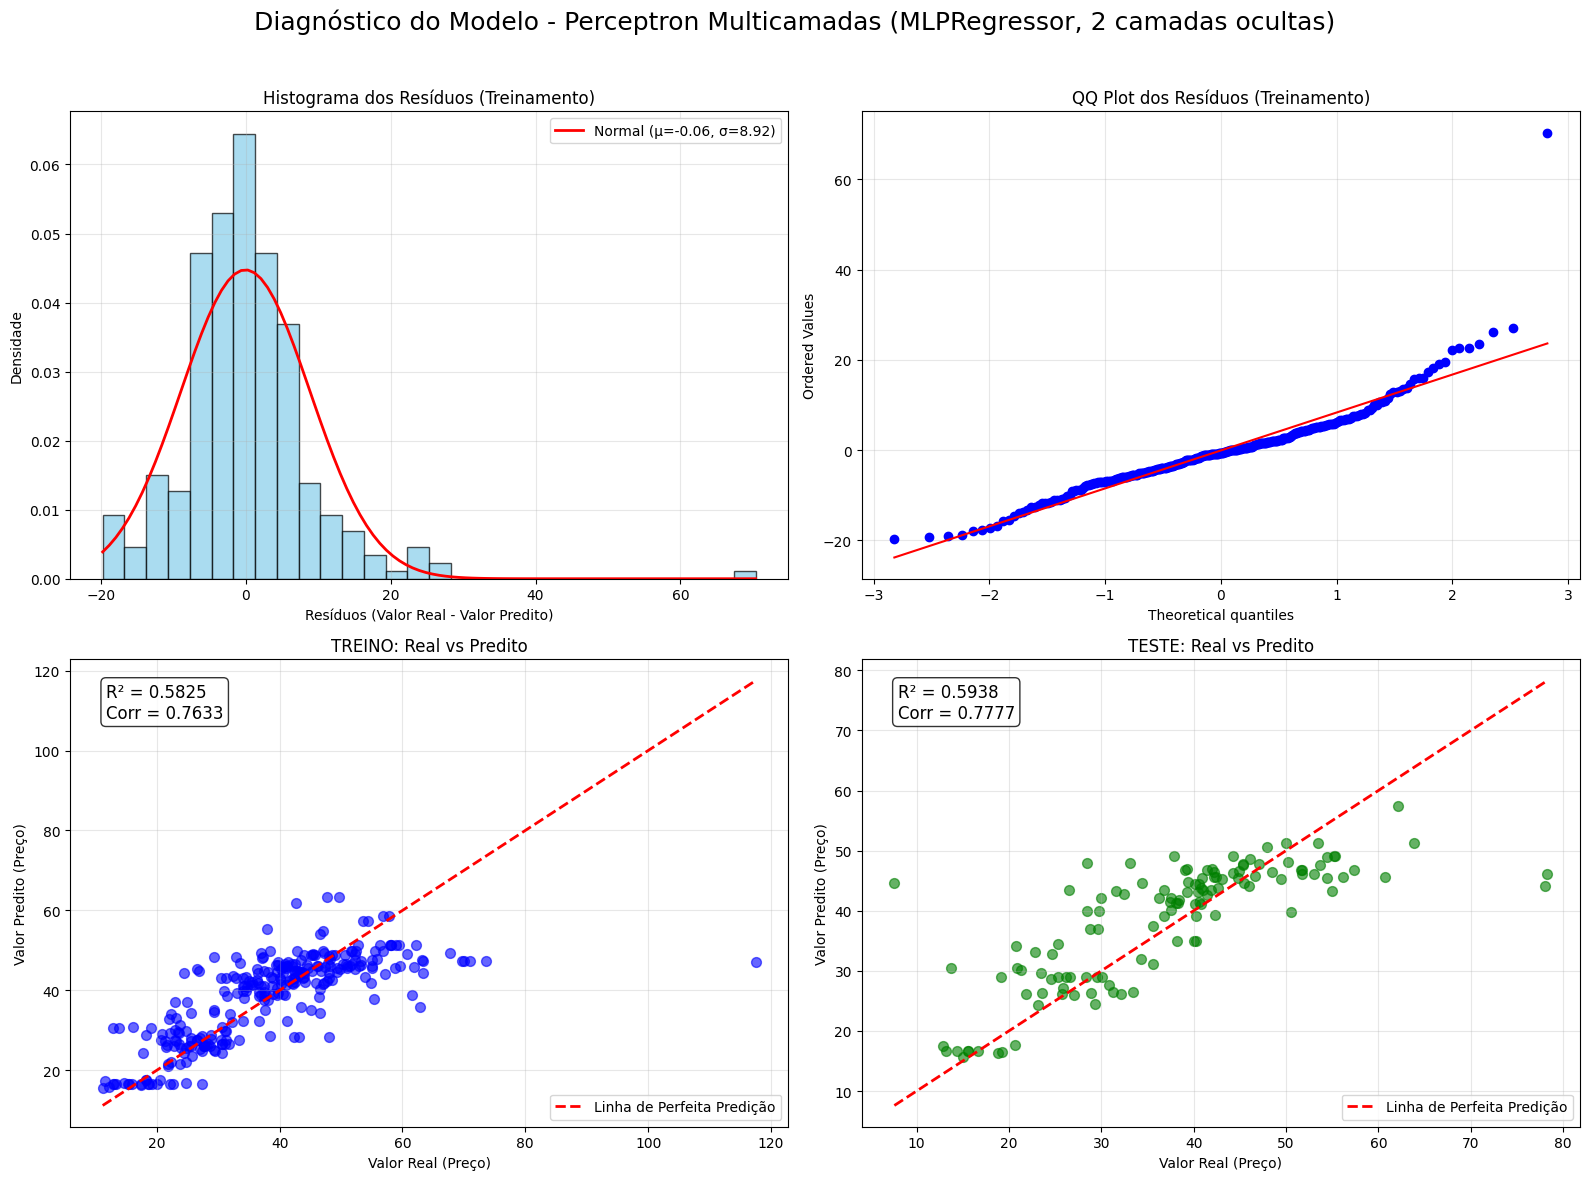

In [78]:
# Perceptron Multicamadas (MLPRegressor) com 2 camadas ocultas
mlp = MLPRegressor(hidden_layer_sizes=(10, 5), activation='relu', max_iter=10000, random_state=11)

# Treinamento do modelo
mlp.fit(X_train, y_train)

# Predição nos conjuntos de treino e teste
y_train_pred_mlp = mlp.predict(X_train)
y_test_pred_mlp = mlp.predict(X_test)

# Avaliação do modelo

mlp_2_corr_train, mlp_2_corr_test, mlp_2_r2_train, mlp_2_r2_test = plot_regression_diagnostics(
    y_train=y_train, 
    y_train_pred=y_train_pred_mlp, 
    y_test=y_test, 
    y_test_pred=y_test_pred_mlp, 
    title='Perceptron Multicamadas (MLPRegressor, 2 camadas ocultas)'
)


Coeficiente de correlação de Pearson (Treino): 0.7473
R² (Treino): 0.5526
Coeficiente de correlação de Pearson (Teste): 0.7616
R² (Teste): 0.5771


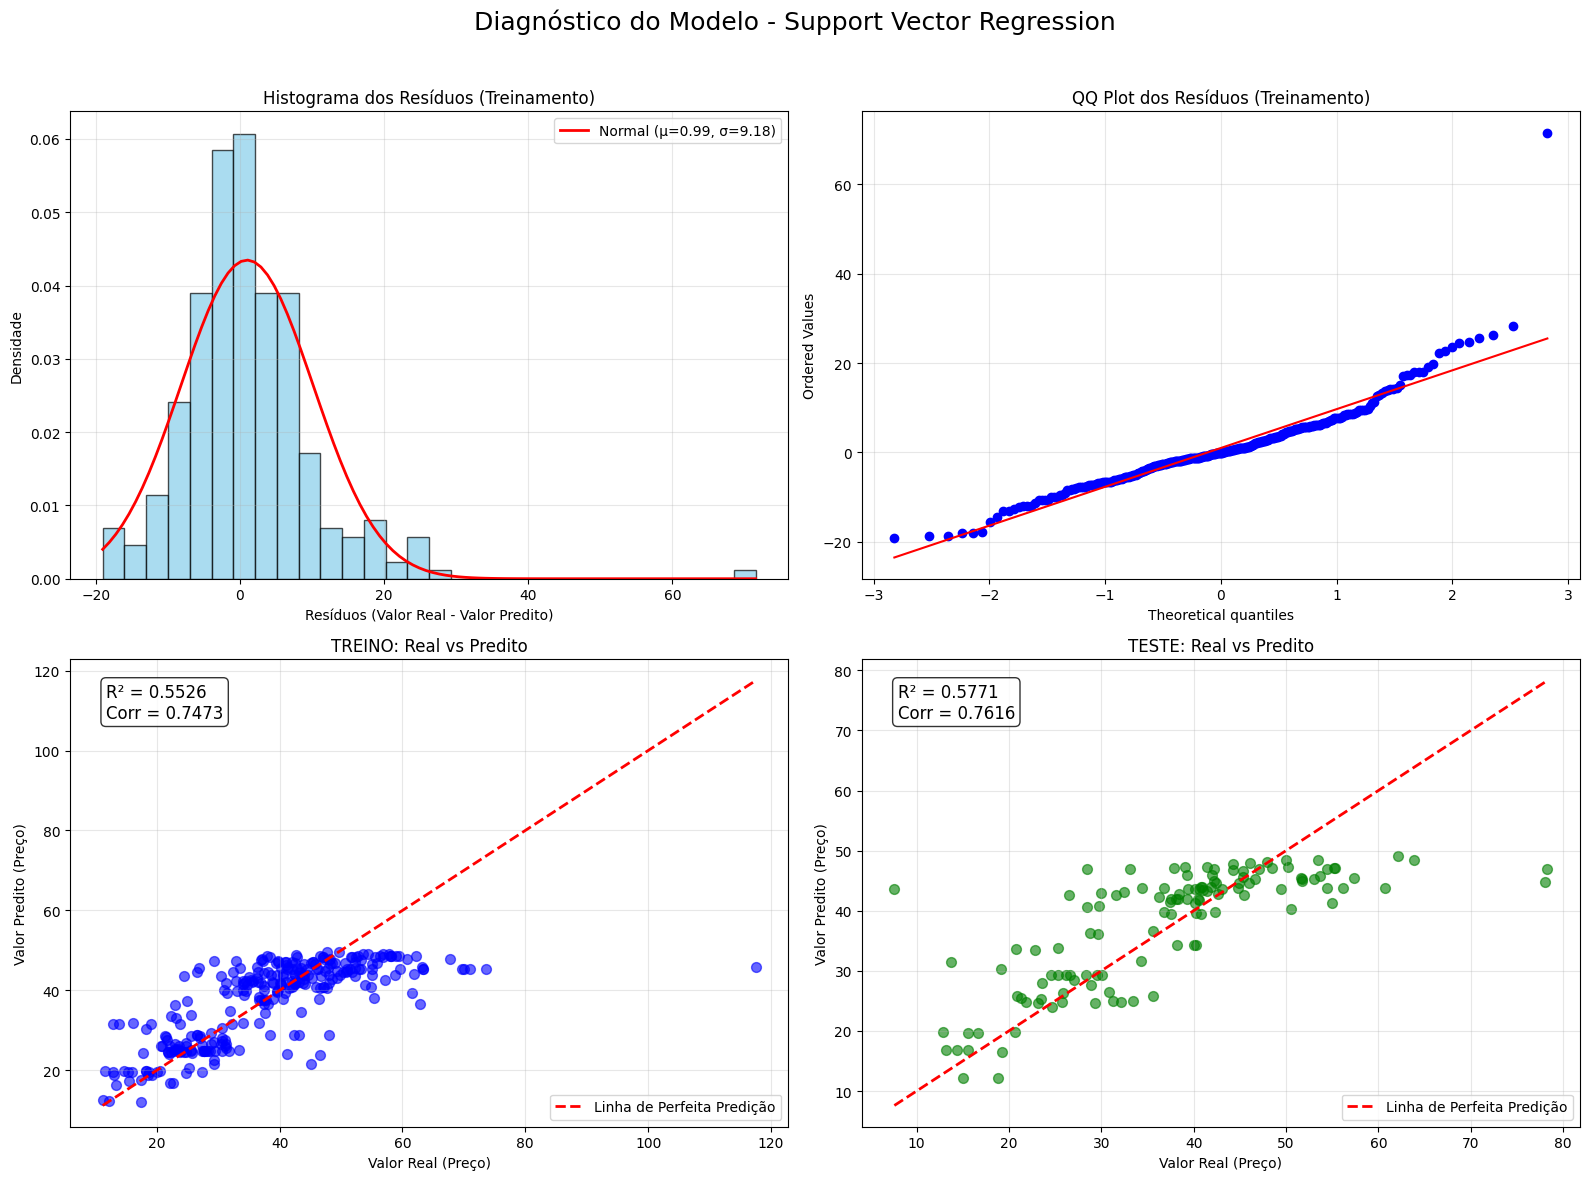

In [79]:
# SVR - Support Vector Regression
from sklearn.svm import SVR

svr = SVR(kernel='rbf', C=10, epsilon=0.1)
svr.fit(X_train, y_train)

y_train_pred_svr = svr.predict(X_train)
y_test_pred_svr = svr.predict(X_test)

svr_corr_train, svr_corr_test, svr_r2_train, svr_r2_test = plot_regression_diagnostics(
    y_train=y_train, 
    y_train_pred=y_train_pred_svr, 
    y_test=y_test, 
    y_test_pred=y_test_pred_svr, 
    title='Support Vector Regression'
)

,Modelo,Corr Treino,Corr Teste,R² Treino,R² Teste
0,Regressão Linear,0.76,0.77,0.58,0.58
1,Regressão Polinomial (degree = 2),0.84,0.81,0.71,0.66
2,Perceptron Simples,0.73,0.74,0.53,0.54
3,MLP (1 camada oculta),0.77,0.80,0.60,0.62
4,MLP (2 camadas ocultas),0.76,0.78,0.58,0.59
5,SVR,0.75,0.76,0.55,0.58


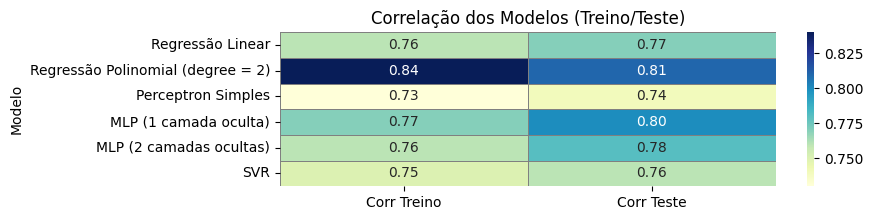

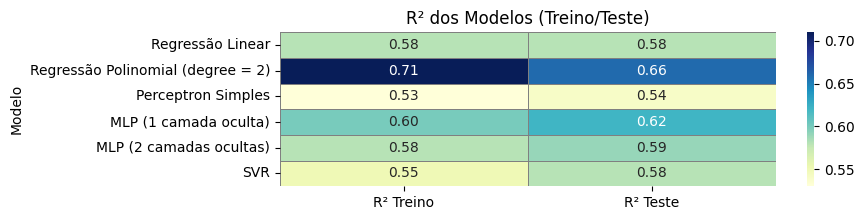

In [80]:
# List all the correlation and r2 results for all the models


# Lista dos resultados de correlação e R² para todos os modelos

results = [
    {
        "Modelo": "Regressão Linear",
        "Corr Treino": round(lr_corr_train, 2),
        "Corr Teste": round(lr_corr_test, 2),
        "R² Treino": round(lr_r2_train, 2),
        "R² Teste": round(lr_r2_test, 2)
    },
    {
        "Modelo": "Regressão Polinomial (degree = 2)",
        "Corr Treino": round(lr_poly_2_corr_train, 2),
        "Corr Teste": round(lr_poly_2_corr_test, 2),
        "R² Treino": round(lr_poly_2_r2_train, 2),
        "R² Teste": round(lr_poly_2_r2_test, 2)
    },
    # {
    #     "Modelo": "Regressão Polinomial (degree = 4)",
    #     "Corr Treino": round(lr_poly_4_corr_train, 2),
    #     "Corr Teste": round(lr_poly_4_corr_test, 2),
    #     "R² Treino": round(lr_poly_4_r2_train, 2),
    #     "R² Teste": round(lr_poly_4_r2_test, 2)
    # },
    {
        "Modelo": "Perceptron Simples",
        "Corr Treino": round(ps_mlp_corr_train, 2),
        "Corr Teste": round(ps_mlp_corr_test, 2),
        "R² Treino": round(ps_mlp_r2_train, 2),
        "R² Teste": round(ps_mlp_r2_test, 2)
    },
    {
        "Modelo": "MLP (1 camada oculta)",
        "Corr Treino": round(mlp_1_corr_train, 2),
        "Corr Teste": round(mlp_1_corr_test, 2),
        "R² Treino": round(mlp_1_r2_train, 2),
        "R² Teste": round(mlp_1_r2_test, 2)
    },
    {
        "Modelo": "MLP (2 camadas ocultas)",
        "Corr Treino": round(mlp_2_corr_train, 2),
        "Corr Teste": round(mlp_2_corr_test, 2),
        "R² Treino": round(mlp_2_r2_train, 2),
        "R² Teste": round(mlp_2_r2_test, 2)
    },
    {
        "Modelo": "SVR",
        "Corr Treino": round(svr_corr_train, 2),
        "Corr Teste": round(svr_corr_test, 2),
        "R² Treino": round(svr_r2_train, 2),
        "R² Teste": round(svr_r2_test, 2)
    }
]

df_results = pd.DataFrame(results)
display(df_results)

# Separar os resultados em dois DataFrames: um para correlação e outro para R²
df_corr = df_results[["Modelo", "Corr Treino", "Corr Teste"]].set_index("Modelo")
df_r2 = df_results[["Modelo", "R² Treino", "R² Teste"]].set_index("Modelo")

# Heatmap para correlação
plt.figure(figsize=(8, 2))
sns.heatmap(
    df_corr,
    annot=True, fmt=".2f", cmap="YlGnBu", cbar=True,
    linewidths=0.5, linecolor='gray'
)
plt.title("Correlação dos Modelos (Treino/Teste)")
plt.yticks(rotation=0)
plt.show()

# Heatmap para R²
plt.figure(figsize=(8, 2))
sns.heatmap(
    df_r2,
    annot=True, fmt=".2f", cmap="YlGnBu", cbar=True,
    linewidths=0.5, linecolor='gray'
)
plt.title("R² dos Modelos (Treino/Teste)")
plt.yticks(rotation=0)
plt.show()




Segundo Brigato e Iocchi (2020), em cenários com amostras limitadas modelos de baixa complexidade podem ser mais robustos ao sobreajuste e até superar arquiteturas mais profundas. 

No que se refere à avaliação da associação linear, Schober, Boer e Schwarte (2018) explicam que coeficientes de correlação de Pearson elevados devem ser interpretados como indicadores de forte relação entre variáveis, enquanto valores moderados ou baixos sugerem associações mais fracas.

Já em relação ao coeficiente de determinação, Chicco, Warrens e Jurman (2021) destacam que, embora o R² seja amplamente utilizado como medida de qualidade do ajuste, sua interpretação deve ser feita em conjunto com outros diagnósticos, como análise de resíduos e gráficos de dispersão, para garantir a validade do modelo.


## Interpretação de Correlação (r) e Coeficiente de Determinação (R²)

| Faixa de valores | Interpretação (r) – Schober et al. (2018) | Interpretação (R²) – Chicco et al. (2021) |
|------------------|-------------------------------------------|--------------------------------------------|
| 0.00 – 0.10      | Desprezível                               | Muito fraco                                 |
| 0.10 – 0.39      | Fraca                                     | Fraco                                       |
| 0.40 – 0.69      | Moderada                                  | Moderado                                    |
| 0.70 – 0.89      | Forte                                     | Moderadamente forte                         |
| 0.90 – 1.00      | Muito forte                               | Forte a muito forte                         |

> **Nota:** Os intervalos para R² são mais dependentes do domínio da aplicação. Os valores acima são sugestões práticas de interpretação, reforçando que o R² deve sempre ser analisado em conjunto com outros diagnósticos (como análise de resíduos e gráficos de dispersão).

---

## Referências

SCHOBER, P.; BOER, C.; SCHWARTE, L. A. Correlation coefficients: appropriate use and interpretation. 
*Anesthesia & Analgesia*, v. 126, n. 5, p. 1763-1768, 2018. DOI: https://doi.org/10.1213/ANE.0000000000002864.  

CHICCO, D.; WARRENS, M. J.; JURMAN, G. The coefficient of determination R² and adjusted R² in regression. 
*Psychological Methods*, v. 26, n. 4, p. 612-635, 2021. DOI: https://doi.org/10.1037/met0000472.  

BRIGATO, L.; IOCCHI, L. A close look at deep learning with small data. 
*Pattern Recognition Letters*, v. 135, p. 96-104, 2020. 
DOI: https://doi.org/10.1016/j.patrec.2020.05.029.  
